In [ ]:
!pip3 install python-chess

In [1]:
import pandas as pd
import ast
from collections import defaultdict as dd
import regex as re
import seaborn as sns
import numpy as np
import chess
from itertools import chain


# Descriptive Analytics

In [ ]:
df = pd.read_csv("sample.csv", header=0, index_col = 0)

In [ ]:
df.head()

In [ ]:
df["BMoves"] = df["BMoves"].apply(ast.literal_eval)
df["WMoves"] = df["WMoves"].apply(ast.literal_eval)

In [ ]:
df = df[df["WMoves"] != "eow"]
df = df[df["BMoves"] != "eow"]

In [ ]:
df.loc[2,'WMoves']

## Most popular square?

In [ ]:
lookups = [
    ("^.*[a-h][1-8].*$", "normal move"),
    ("^O-O$", "kingside castle"),
    ("^O-O-O$", "queenside castle"),
    ("^.+[QNBR]\+*#*$", "pawn conversion"),
    ("^.*\+$", "check"),
    ("^.*#$", "checkmate")
]

def is_not_castle(move):
    return not bool(re.search("O-O",move))


In [ ]:
square_dict = dd(int)

def count_squares(moves, colour):
    for move in moves:
        if is_not_castle(move):
            square_dict[re.findall("[a-h][1-8]",move)[-1]] += 1
        else:
            if re.search("^O-O$", move):
                if colour=="W":
                    square_dict["g1"] += 1
                else:
                    square_dict["g8"] += 1
            else: 
                if colour=="W":
                    square_dict["c1"] += 1
                else:
                    square_dict["c8"] += 1
    return


In [ ]:
df["BMoves"].apply(lambda x : count_squares(x,'B'))
df["WMoves"].apply(lambda x : count_squares(x,'W'))

## How many moves until a game becomes unique?

In [ ]:
df.loc[195]

In [ ]:
sample_df = df.head(1000)

In [ ]:
moves_until_unique = dd(int)

for i in range(len(sample_df["WMoves"])):
    for j in range(i,len(sample_df["WMoves"])):
        move_count = -1
        g1move = ""
        g2move = ""
        while g1move==g2move:
            move_count += 1
            try:
                if move_count%2 == 0:
                    #White's move
                    g1move = df["WMoves"][i][move_count//2]
                    g2move = df["WMoves"][j][move_count//2]
                else:
                    #Black's move
                    g1move = df["BMoves"][i][move_count//2]
                    g2move = df["BMoves"][j][move_count//2]
            except:
                #end of game
                g1move = 1
                g2move = 2
        if moves_until_unique[i] < move_count:
            moves_until_unique[i] = move_count
        if moves_until_unique[j] < move_count:
            moves_until_unique[j] = move_count
            

In [ ]:
moves_until_unique

## CapturesByPiece
function takes as argument the pandas dataframe and returns the pandas dataframe with capture count for pair of pieces

In [ ]:
def capturesByPiece(df):
    # Dict of dict to store the count of captures made by a piece

    captureCount = dict()
    for attacker in chess.UNICODE_PIECE_SYMBOLS.keys():
        captureCount[attacker] = dict()
        for captured in chess.UNICODE_PIECE_SYMBOLS.keys():
            captureCount[attacker][captured] = 0
    
  
            
    for index, row in df.iterrows():
        WMoves = row["WMoves"]
        BMoves = row["BMoves"]

        board = chess.Board()

        # zipping all the moves and merging into one list 
        allMoves = zip(WMoves, BMoves)
        zippedMoves = list(chain.from_iterable(allMoves))

        for move in zippedMoves:
            if board.is_capture(board.parse_san(move)):
                moveInUCI = board.uci(board.parse_san(move))
#                 print("move:",move)
                attackerPosition, capturedPosition = moveInUCI[:2], moveInUCI[2:4]
#                 print("ap,cp:"+attackerPosition, capturedPosition)
                attacker = board.piece_at(chess.SQUARE_NAMES.index(attackerPosition))
                captured = board.piece_at(chess.SQUARE_NAMES.index(capturedPosition))
#                 print("a,c:",attacker,captured)
                
                if (str(attacker) in captureCount.keys()) and (str(captured) in captureCount.keys()):
                    captureCount[str(attacker)][str(captured)] += 1
        
            board.push_san(move)
        
#         print()
    
    capture_count = pd.DataFrame(captureCount)
    capture_count.rename(columns = chess.UNICODE_PIECE_SYMBOLS, index =  chess.UNICODE_PIECE_SYMBOLS, inplace = True) 

    return  capture_count

In [ ]:
%%time
sns.heatmap(capturesByPiece(df.head(5)), cmap="YlGnBu")

# Prescriptive Analytics

## Feature Engineering

## Add columns for who won game

In [ ]:
def get_player_result(result, colour):
    if colour=='B':
        if result[-1]=='0':
            return 0
        else:
            return 1
    else:
        if result[0]=='0':
            return 0
        else:
            return 1

def add_WL_columns(df):
    df['WResult'] = df["Result"].apply(lambda x: get_player_result(x, 'W'))
    df['BResult'] = df["Result"].apply(lambda x: get_player_result(x, 'B'))
    return

In [ ]:
add_WL_columns(df)

## Add columns for pawn conversions

In [ ]:
def get_conversions(moves):
    conversions = []
    for move in moves:
        if re.match(lookups[3][0], move) is not None:
            conversions.append(re.search("(?<=[a-h][1-8]=)[QNBR]",move).group(0))
    return len(conversions)

def add_conversions_columns(df):
    df["WConversions"] = df["WMoves"].apply(lambda x: get_conversions(x))
    df["BConversions"] = df["BMoves"].apply(lambda x: get_conversions(x))

In [ ]:
add_conversions_columns(df)

**Add columns for what piece was used the most by a player**

In [ ]:
df['WFavPiece'] = 'null'
df['BFavPiece'] = 'null'

WPieceMoves = {'N': 0, 'B': 0, 'R': 0, 'Q': 0, 'K':0}
BPieceMoves = {'N': 0, 'B': 0, 'R': 0, 'Q': 0, 'K':0}

def get_favPiece():
    for i in range(len(df)):
        moves = df.loc[i, 'WMoves']
        for move in moves:
            if(move):
                if move[0].isupper() and move[0] != 'O':
                    WPieceMoves[move[0]] += 1
        FavPiece = max(WPieceMoves, key=WPieceMoves.get)
        df.loc[i, ['WFavPiece']] = FavPiece
        
        moves = df.loc[i, 'BMoves']
        for move in moves:
            if(move):
                if move[0].isupper() and move[0] != 'O':
                    BPieceMoves[move[0]] += 1
        FavPiece = max(BPieceMoves, key=BPieceMoves.get)
        df.loc[i, ['BFavPiece']] = FavPiece

In [ ]:
get_favPiece()

## Moves Count
Moves can either be ordinary move or capturing move, 
 - `WCaptureMovesCount` represent number of capturing moves in the game made by White player
 - `BCaptureMovesCount` represent number of capturing moves in the game made by Black player
 - `WOrdMovesCount` represent number of ordinary moves in the game made by White player
 - `BOrdMovesCount` represent number of oridnary moves in the game made by Black player

In [ ]:
def captureCount(moves):
    count = 0
    for move in moves:
        if "x" in move:
            count += 1
    return count
            

In [ ]:
def ordinaryCount(moves):
    count = 0
    for move in moves:
        if "x" not in move:
            count += 1
    return count

In [ ]:
def addmovesCount():
    df["WCaptureMovesCount"] = df["WMoves"].apply(captureCount)
    df["BCaptureMovesCount"] = df["BMoves"].apply(captureCount)

    df["WOrdMovesCount"] = df["WMoves"].apply(ordinaryCount)

    df["BOrdMovesCount"] = df["BMoves"].apply(ordinaryCount)

In [ ]:
addmovesCount()

## Number of pieces at the end of the game

In [ ]:
def addpieces():
    df["WPiecesCount"] = np.abs(df["BCaptureMovesCount"].subtract(16))

    df["BPiecesCount"] = np.abs(df["WCaptureMovesCount"].subtract(16))

In [ ]:
addpieces()

## Pairwise capture count
    - Uppercase letter(R,N,B,Q,K,P) represent White pieces 
    - lowercase letter(r,n,b,q,k,p) represent Black pieces
    - Column "Pp" represent P captures p count

In [ ]:
def pairCaptureDict(WMoves, BMoves):
#     Dictionary to store count
    captureCount = dict()
    for attacker in chess.UNICODE_PIECE_SYMBOLS.keys():
        for captured in chess.UNICODE_PIECE_SYMBOLS.keys():
            key = attacker+captured
            if (not key.isupper()) and (not key.islower()):
                captureCount[key] = 0
                
                
    board = chess.Board()
 # zipping all the moves and merging into one list 
    allMoves = zip(WMoves, BMoves)
    zippedMoves = list(chain.from_iterable(allMoves))

    for move in zippedMoves:
        if board.is_capture(board.parse_san(move)):
            moveInUCI = board.uci(board.parse_san(move))
#                 print("move:",move)
            attackerPosition, capturedPosition = moveInUCI[:2], moveInUCI[2:4]
#                 print("ap,cp:"+attackerPosition, capturedPosition)
            attacker = board.piece_at(chess.SQUARE_NAMES.index(attackerPosition))
            captured = board.piece_at(chess.SQUARE_NAMES.index(capturedPosition))
#                 print("a,c:",attacker,captured)
            key = (str(attacker)+str(captured))
            if (key in captureCount.keys()):
                    captureCount[key] += 1
        board.push_san(move)
    return captureCount


In [ ]:
#  Adds the features to the dataframe 
df['pairCaptureDict'] = df.apply(lambda x: pairCaptureDict(x.WMoves, x.BMoves), axis=1)

new_df = pd.DataFrame(list(df["pairCaptureDict"]))

df = pd.concat([df, new_df], axis=1)

df = df.drop(columns = "pairCaptureDict")

In [ ]:
df.head()

## finding first check

In [ ]:
def find_check(entry):
    n_moves = 0;
    for i in range(len(entry["WMoves"])):
        n_moves+=1
        if entry["WMoves"][i][-1] == "+":
            return n_moves
        if i == len(entry["WMoves"]) - 1 and len(entry["WMoves"]) != len(entry["BMoves"]):
            return -1
        if entry["BMoves"][i][-1] == "+":
            return n_moves
    return -1

def find_checks(df):
    chks = []
    for i in range(len(df)):
        chks.append(find_check(df.iloc[i]))
    df["first_check"] = chks

In [ ]:
def find_first_check(moves):
    for i in range(len(moves)):
        if moves[i][-1] == "+":
            return i
    return len(moves)

def get_check(moves):
    for i in range(len(moves)):
        if moves[i][-1] == "+":
            return i
    else:
        return 0

def make_check_columns(df):
    df["BCheck"] = df["BMoves"].apply(lambda x: get_check(x))
    df["WCheck"] = df["WMoves"].apply(lambda x: get_check(x))
    df["BChecked"] = df["WMoves"].apply(lambda x: get_check(x))
    df["WChecked"] = df["BMoves"].apply(lambda x: get_check(x))

In [ ]:
make_check_columns(df)

In [58]:
pd.set_option('display.max_columns', None)

## High skill openings

In [ ]:
def high_skill_openings(df):
    open_elo = dd(int)
    open_count = dd(int)
    bOpens = []
    wOpens = []
    for i in range(len(df)):
        wOpen = tuple(df["WMoves"][i][0:5])
        wOpens.append(wOpen)
        wSkill = df["WElo"][i]
        open_elo[wOpen] += int(wSkill)
        open_count[wOpen] += 1
        bOpen = tuple(df["BMoves"][i][0:5])
        bOpens.append(wOpen)
        bSkill = df["BElo"][i]
        open_elo[bOpen] += bSkill
        open_count[bOpen] += 1
        
    for key in open_elo.keys():
        open_elo[key] = open_elo[key]/open_count[key]
    return open_elo, bOpens, wOpens

def openings(df):
    elos, bOpens, wOpens = high_skill_openings(df)
    df["bOpens"] = bOpens
    df["wOpens"] = wOpens

In [ ]:
openings(df)

In [ ]:
df.head()

**Score Calculation**

In [ ]:
InitialBoardW = ['Pa2', 'Pb2', 'Pc2', 'Pd2', 'Pe2', 'Pf2', 'Pg2', 'Ph2', 'Ra1', 'Nb1', 'Bc1', 'Qd1', 'Ke1', 'Bf1', 'Ng1', 'Rh1']
InitialBoardB = ['Pa7', 'Pb7', 'Pc7', 'Pd7', 'Pe7', 'Pf7', 'Pg7', 'Ph7', 'Ra8', 'Nb8', 'Bc8', 'Qd8', 'Ke8', 'Bf8', 'Ng8', 'Rh8']

PieceVal = {'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K':100}

def calculateScore(movesList):
    scoreW = scoreB = 39                                                                                                                           
    for i in range(len(movesList)):
        if 'x' in movesList[i]:       
            posIndex = movesList[i].index('x') + 1
            position = movesList[i][posIndex:]
            j = i-1     
            while j >= 0:
                if position in movesList[j]:
                    if position[0] == movesList[j][0]:
                        if j%2 == 1:
                            scoreB -= 1
                        else:
                            scoreW -= 1
                    elif 'x' in movesList[j]:
                        if movesList[j][0].islower():
                            if j%2 == 1:
                                scoreB -= 1
                            else:
                                scoreW -= 1
                        else:
                            if j%2 == 1:
                                scoreB -= PieceVal[movesList[j][0]]
                            else:
                                scoreW -= PieceVal[movesList[j][0]]
                            
                    else:
                        if j%2 == 1:
                            scoreB -= PieceVal[movesList[j][0]]
                        else:
                            scoreW -= PieceVal[movesList[j][0]]
                j -= 1
                
            if i%2 == 0:
                for piece in InitialBoardB:
                    if position in piece:
                        scoreB -= PieceVal[piece[0]]
            else:
                for piece in InitialBoardW:
                    if position in piece:
                        scoreW -= PieceVal[piece[0]]        
        
    return scoreW, scoreB

In [ ]:
completeList = []
for i in range(len(df)):
    moves = []
    wmoves = df.loc[i,'WMoves']
    bmoves = df.loc[i,'BMoves']
    if len(wmoves) > len(bmoves):
        for k in range(len(bmoves)):
            moves.append(wmoves[k])
            moves.append(bmoves[k])
        #moves.append(wmoves[k+1])
    elif len(wmoves) == len(bmoves):
        for k in range(len(bmoves)):
            moves.append(wmoves[k])
            moves.append(bmoves[k])
    else:
        for k in range(len(wmoves)):
            moves.append(wmoves[k])
            moves.append(bmoves[k])
        moves.append(bmoves[k+1])
    completeList.append(moves)
df['Moves'] = completeList

In [ ]:
wscoreList = []
bscoreList = []
for i in range(len(df)):
    w, b = calculateScore(df.loc[i, 'Moves'])
    wscoreList.append(w)
    bscoreList.append(b)
    
df['WScore'] = wscoreList
df['BScore'] = bscoreList

In [ ]:
df.head(1)

## one hot encoding for `ECO` column

In [ ]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df['ECO'])
# Drop column B as it is now encoded
df = df.drop('ECO',axis = 1)
# Join the encoded df
df = df.join(one_hot)

In [ ]:
df.head(1)

In [ ]:
df.to_csv("sample1.csv")

# Feature Selection
https://machinelearningmastery.com/feature-selection-for-regression-data/

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RANSACRegressor, Perceptron, RidgeCV, SGDRegressor, ElasticNetCV, LarsCV, LassoCV, LassoLarsCV, OrthogonalMatchingPursuitCV, BayesianRidge, ARDRegression, MultiTaskElasticNetCV, PoissonRegressor, TweedieRegressor, GammaRegressor, enet_path
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
# example of correlation feature selection for numerical data
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [22]:
df = pd.read_csv("sample1.csv")

/home/student.unimelb.edu.au/jmohammed/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3,6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
df.head()

,Unnamed: 0,Event,Site,GameNumber,WName,BName,WElo,BElo,WRD,BRD,...,E88,E90,E91,E92,E93,E94,E95,E97,E98,E99
0,0,FICS rated blitz game,FICS freechess.org,470452425,chesspickle,lawrencegern,1963,764,21.2,112.2,...,0,0,0,0,0,0,0,0,0,0
1,1,FICS rated blitz game,FICS freechess.org,470452424,ZoneBlindTal,AhNeow,1600,1487,36.6,28.5,...,0,0,0,0,0,0,0,0,0,0
2,2,FICS rated blitz game,FICS freechess.org,470452423,forlat,naraindra,1948,1089,15.3,30.7,...,0,0,0,0,0,0,0,0,0,0
3,3,FICS rated blitz game,FICS freechess.org,470452420,PGierech,kkpsA,1497,1224,32.4,37.6,...,0,0,0,0,0,0,0,0,0,0
4,4,FICS rated blitz game,FICS freechess.org,470452419,Liszt,Sotavaunu,1594,1554,26.8,34.9,...,0,0,0,0,0,0,0,0,0,0


In [24]:
BX = df[["PlyCount","WResult","BResult","WConversions","BConversions","WCaptureMovesCount","BCaptureMovesCount","WOrdMovesCount","BOrdMovesCount","WPiecesCount","BPiecesCount","Rr","Rn","Rb","Rq","Rk","Rp","rR","rN","rB","rQ","rK","rP","Nr","Nn","Nb","Nq","Nk","Np","nR","nN","nB","nQ","nK","nP","Br","Bn","Bb","Bq","Bk","Bp","bR","bN","bB","bQ","bK","bP","Qr","Qn","Qb","Qq","Qk","Qp","qR","qN","qB","qQ","qK","qP","Kr","Kn","Kb","Kq","Kk","Kp","kR","kN","kB","kQ","kK","kP","Pr","Pn","Pb","Pq","Pk","Pp","pR","pN","pB","pQ","pK","pP","BCheck","WCheck","BChecked","WChecked","WScore","BScore","A00","A01","A02","A03","A04","A05","A06","A07","A08","A09","A10","A11","A12","A13","A14","A15","A16","A17","A18","A19","A20","A21","A22","A23","A24","A25","A26","A27","A28","A29","A30","A31","A32","A33","A34","A35","A36","A37","A38","A39","A40","A41","A42","A43","A44","A45","A46","A47","A48","A49","A50","A51","A52","A53","A54","A55","A56","A57","A58","A59","A60","A65","A68","A69","A70","A72","A80","A81","A82","A83","A84","A85","A86","A87","A89","A90","A91","A92","A95","A96","B00","B01","B02","B03","B04","B05","B06","B07","B08","B09","B10","B11","B12","B13","B14","B15","B16","B17","B18","B19","B20","B21","B22","B23","B24","B25","B26","B27","B28","B29","B30","B31","B32","B33","B34","B35","B36","B38","B40","B41","B42","B43","B44","B45","B46","B47","B49","B50","B51","B52","B53","B54","B56","B57","B58","B60","B62","B63","B70","B71","B72","B73","B74","B75","B76","B77","B78","B80","B81","B82","B83","B84","B86","B87","B88","B90","B92","B94","B95","B96","B97","B98","C00","C01","C02","C03","C05","C06","C07","C10","C11","C12","C13","C14","C15","C16","C17","C18","C19","C20","C21","C22","C23","C24","C25","C26","C27","C28","C29","C30","C31","C32","C33","C34","C35","C36","C37","C38","C39","C40","C41","C42","C43","C44","C45","C46","C47","C48","C49","C50","C51","C52","C53","C54","C55","C56","C57","C58","C60","C61","C62","C63","C64","C65","C66","C67","C68","C69","C70","C71","C74","C75","C77","C78","C79","C80","C82","C84","C87","C88","C89","C91","C92","C93","D00","D01","D02","D03","D04","D05","D06","D07","D08","D09","D10","D11","D12","D13","D14","D15","D16","D17","D18","D20","D21","D22","D23","D24","D25","D26","D28","D29","D30","D31","D32","D33","D34","D35","D36","D37","D38","D40","D41","D43","D44","D45","D46","D47","D48","D50","D51","D52","D53","D55","D56","D57","D58","D60","D61","D63","D66","D67","D70","D73","D77","D78","D79","D80","D82","D85","D87","D90","D91","D92","D93","D94","D96","D97","D98","E00","E01","E04","E05","E06","E07","E09","E10","E11","E12","E13","E14","E15","E16","E17","E18","E19","E20","E21","E22","E23","E24","E27","E30","E32","E34","E36","E38","E39","E40","E42","E43","E46","E48","E56","E60","E61","E62","E65","E66","E67","E70","E71","E72","E73","E76","E77","E80","E81","E82","E83","E85","E86","E87","E88","E90","E91","E92","E93","E94","E95","E97","E98","E99"]]
By = df["BElo"]

In [25]:
train_bx, test_bx, train_by, test_by= train_test_split(BX, By)

In [26]:
train_by.head()

22816    1578
34471    1747
33667    1027
2244     1228
33203    1749
Name: BElo, dtype: int64

# Model Building

In [ ]:
models = [LinearRegression, RidgeCV, SGDRegressor, ElasticNetCV, LarsCV, LassoCV, LassoLarsCV, OrthogonalMatchingPursuitCV, BayesianRidge, RANSACRegressor, AdaBoostRegressor, ARDRegression, PoissonRegressor, TweedieRegressor, GammaRegressor, GradientBoostingRegressor,MLPRegressor ]
for model in models:
    cur_model = model()
    cur_model.fit(train_bx, train_by)
    by_pred = cur_model.predict(test_bx)
    print("{}: r2:{} MSE:{}".format(type(cur_model).__name__, r2_score(test_by, by_pred),mean_squared_error(test_by,by_pred)))


In [19]:
train_bx

,PlyCount,WResult,BResult,WConversions,BConversions,WCaptureMovesCount,BCaptureMovesCount,WOrdMovesCount,BOrdMovesCount,WPiecesCount,...,E88,E90,E91,E92,E93,E94,E95,E97,E98,E99
13370,107,1,0,0,0,15,12,39,41,4,...,0,0,0,0,0,0,0,0,0,0
32878,71,1,0,0,0,8,7,28,28,9,...,0,0,0,0,0,0,0,0,0,0
4988,69,1,0,0,0,10,8,25,26,8,...,0,0,0,0,0,0,0,0,0,0
20146,44,0,1,0,0,4,4,18,18,12,...,0,0,0,0,0,0,0,0,0,0
19482,3,1,0,0,0,1,0,1,1,16,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18943,81,1,0,0,0,10,9,31,31,7,...,0,0,0,0,0,0,0,0,0,0
20838,38,0,1,0,0,4,5,15,14,11,...,0,0,0,0,0,0,0,0,0,0
9774,48,0,1,0,0,3,3,21,21,13,...,0,0,0,0,0,0,0,0,0,0
8237,31,1,0,0,0,5,4,11,11,12,...,0,0,0,0,0,0,0,0,0,0


In [18]:
test_bx

,PlyCount,WResult,BResult,WConversions,BConversions,WCaptureMovesCount,BCaptureMovesCount,WOrdMovesCount,BOrdMovesCount,WPiecesCount,...,E88,E90,E91,E92,E93,E94,E95,E97,E98,E99
38330,80,0,1,0,0,10,11,30,29,5,...,0,0,0,0,0,0,0,0,0,0
2359,63,1,0,1,0,11,8,21,23,8,...,0,0,0,0,0,0,0,0,0,0
24050,55,1,0,0,0,5,5,23,22,11,...,0,0,0,0,0,0,0,0,0,0
23573,128,0,1,0,1,11,12,53,52,4,...,0,0,0,0,0,0,0,0,0,0
32511,58,1,0,0,0,10,5,19,24,11,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,150,0,1,0,1,14,15,61,60,1,...,0,0,0,0,0,0,0,0,0,0
39154,33,1,0,0,0,3,2,14,14,14,...,0,0,0,0,0,0,0,0,0,0
16150,56,0,1,0,0,6,13,22,15,3,...,0,0,0,0,0,0,0,0,0,0
16120,74,0,1,0,0,7,7,30,30,9,...,0,0,0,0,0,0,0,0,0,0


## Linear Regression

In [7]:
reg = LinearRegression().fit(train_bx, train_by)

$R^2$

In [8]:
reg.score(train_bx, train_by)

0.1696770999706142

#### Training scores

MSE

In [14]:
print(format(mean_squared_error(train_by,reg.predict(train_bx)), '.8f'))

43411.13328594


In [38]:
mean_absolute_error(train_by, reg.predict(train_bx))

162.40681135465303

#### Test scores

MSE

In [16]:
print(format(mean_squared_error(test_by, reg.predict(test_bx)), '.8f'))

24693042425047012.00000000


MAE

In [28]:
mean_absolute_error(test_by, reg.predict(test_bx))

165.45356737206686

## Ridge

In [47]:
from sklearn.linear_model import RidgeCV
rid = RidgeCV()
rid.fit(train_bx, train_by)


RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [52]:
rid.alpha_

1.0

$R^2$

In [40]:
rid.score(train_bx, train_by)

0.16892790839812

In [87]:
pd.Series(rid.coef_, index = train_bx.columns)

PlyCount          8.188577
WResult           5.957003
BResult          80.853624
WConversions     11.948780
BConversions     -5.175080
                   ...    
E94            -215.259640
E95              88.749552
E97              40.137949
E98             228.083708
E99              48.734874
Length: 472, dtype: float64

In [88]:
rid.intercept_

1879.6728168546715

#### Training scores

MSE

In [41]:
print(format(mean_squared_error(train_by,rid.predict(train_bx)), '.8f'))

43450.30269245


MAE

In [42]:
mean_absolute_error(train_by, rid.predict(train_bx))

162.51370033336934

#### Test scores

MSE

In [43]:
print(format(mean_squared_error(test_by, rid.predict(test_bx)), '.8f'))

45282.26656808


MAE

In [44]:
mean_absolute_error(test_by, rid.predict(test_bx))

165.4744840713309

## Lasso

In [45]:
from sklearn.linear_model import LassoCV
las = LassoCV()
las.fit(train_bx, train_by)


LassoCV()

$R^2$

In [46]:
las.score(train_bx, train_by)

0.0862081746821548

#### Training scores

MSE

In [47]:
print(format(mean_squared_error(train_by,las.predict(train_bx)), '.8f'))

47775.07488119


MAE

In [48]:
mean_absolute_error(train_by, las.predict(train_bx))

172.09617458520384

#### Test scores

MSE

In [49]:
print(format(mean_squared_error(test_by, las.predict(test_bx)), '.8f'))

48813.85397197


MAE

In [50]:
mean_absolute_error(test_by, las.predict(test_bx))

173.28148456149432

## Ridge in statsmodels
https://stackoverflow.com/questions/40072870/statistical-summary-table-in-sklearn-linear-model-ridge

In [27]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [73]:
model = sm.OLS(train_by, sm.add_constant(train_bx))

In [74]:
results_fu = model.fit()

In [76]:
frames = []
for n in np.arange(0, 5, 1).tolist():
    results_fr = model.fit_regularized(L1_wt=0, alpha=n, start_params=results_fu.params)

    results_fr_fit = sm.regression.linear_model.OLSResults(model, 
                                                           results_fr.params, 
                                                           model.normalized_cov_params)
    frames.append(np.append(results_fr.params, results_fr_fit.ssr))

    alpha = pd.DataFrame(frames, columns= (["intercept"]+train_bx.columns.tolist() + ['ssr*']))
alpha.index=np.arange(0, 5, 1).tolist()
alpha.index.name = 'alpha*'
alpha.T

alpha*,0,1,2,3,4
intercept,2.149040e+13,4.282227e+00,4.133553e+00,3.999637e+00,3.877954e+00
PlyCount,1.931738e+14,1.690978e+01,1.642865e+01,1.601965e+01,1.567282e+01
WResult,1.358585e+02,-5.853419e+00,-2.844059e+00,-1.582582e+00,-8.973306e-01
BResult,1.720947e+02,1.134791e+01,7.474407e+00,5.842569e+00,4.920149e+00
WConversions,1.088330e+02,-4.717244e-01,-5.357957e-01,-5.312458e-01,-5.160771e-01
...,...,...,...,...,...
E95,-1.418991e+12,9.342477e-03,4.933182e-03,3.448283e-03,2.701590e-03
E97,-1.418991e+12,2.607683e-02,1.401582e-02,9.827069e-03,7.675468e-03
E98,-1.418991e+12,3.040382e-02,1.594807e-02,1.099329e-02,8.473368e-03
E99,-1.418991e+12,6.563913e-03,3.361119e-03,2.269945e-03,1.719966e-03


Text(0.5, 1.0, 'SSR')

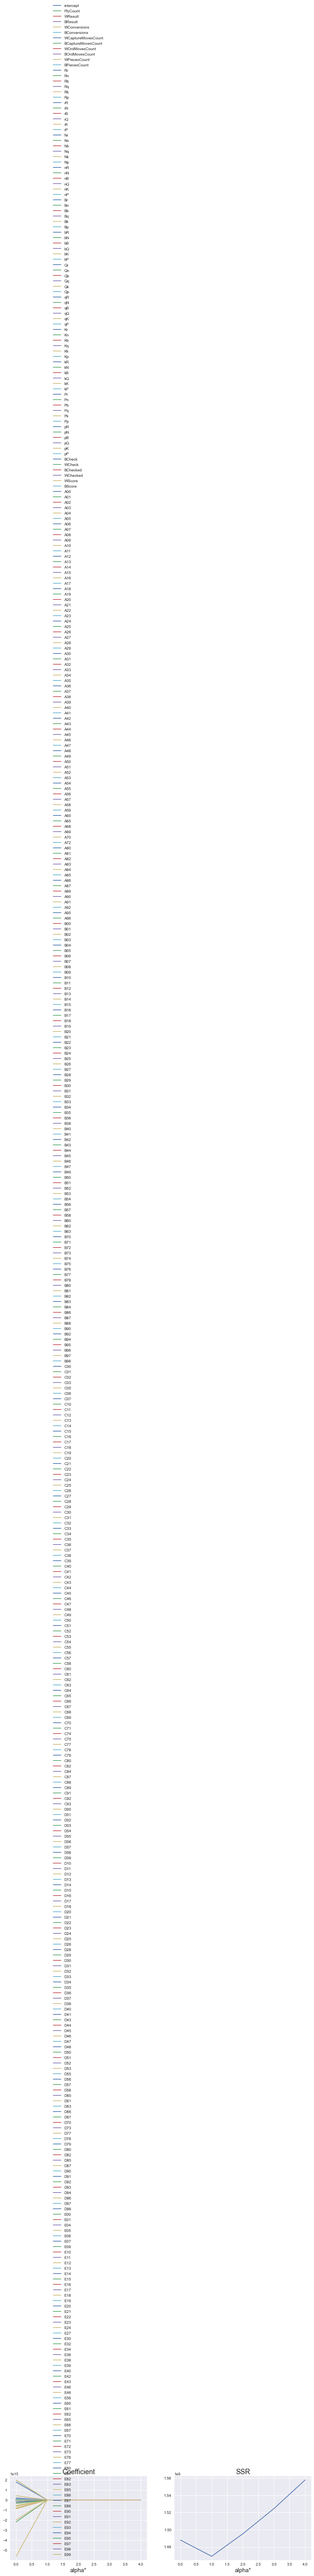

In [77]:
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ax[0] = alpha.iloc[:, :-1].plot(ax=ax[0])
ax[0].set_title('Coefficient')

ax[1] = alpha.iloc[:, -1].plot(ax=ax[1])
ax[1].set_title('SSR')

In [91]:
results_fr = model.fit_regularized(L1_wt=0, alpha=1)

In [93]:
final = sm.regression.linear_model.OLSResults(model, 
                                              results_fr.params, 
                                              model.normalized_cov_params)
final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BElo   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2.857
Date:                Sun, 18 Oct 2020   Prob (F-statistic):           9.86e-79
Time:                        01:44:05   Log-Likelihood:            -2.0104e+05
No. Observations:               29445   AIC:                         4.030e+05
Df Residuals:                   28995   BIC:                         4.067e+05
Df Model:                         449                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  4.2822      0.219     19.534      0.000       3.853       4.712
PlyCount              16.9098      2.323      7.281      0.000      12.357      21.462
WResult               -5.8534      8.313     -0.704      0.481     -22.147      10.440
BResult               11.3479      8.252      1.375      0.169      -4.827      27.523
WConversions          -0.4717      5.099     -0.093      0.926     -10.467       9.523
BConversions          -0.4707      5.070     -0.093      0.926     -10.408       9.467
WCaptureMovesCount    19.7116      3.496      5.638      0.000      12.859      26.564
BCaptureMovesCount    26.6922      6.956      3.837      0.000      13.059      40.326
WOrdMovesCount       -13.7477      7.006     -1.962      0.050     -27.479      -0.016
BOrdMovesCount       -15.7463      6.735     -2.338      0.019     -28.947      -2.546
WPiecesCount          41.8235      4.206      9.944      0.000      33.580      50.067
BPiecesCount          48.8040      4.340     11.246      0.000      40.298      57.310
Rr                     1.4020      4.814      0.291      0.771      -8.033      10.837
Rn                     0.8559      5.636      0.152      0.879     -10.192      11.903
Rb                     1.0444      5.377      0.194      0.846      -9.495      11.583
Rq                     0.8314      6.567      0.127      0.899     -12.041      13.704
Rk                  4.042e-14   1.25e-11      0.003      0.997   -2.45e-11    2.46e-11
Rp                     0.0494      3.935      0.013      0.990      -7.663       7.761
rR                     1.9197     11.697      0.164      0.870     -21.007      24.846
rN                     2.0757     11.978      0.173      0.862     -21.403      25.554
rB                     2.0189     11.913      0.169      0.865     -21.332      25.370
rQ                     0.9081     12.484      0.073      0.942     -23.562      25.378
rK                  5.037e-14    2.9e-12      0.017      0.986   -5.64e-12    5.74e-12
rP                    -0.8702     11.239     -0.077      0.938     -22.900      21.160
Nr                    -0.5739      5.928     -0.097      0.923     -12.193      11.045
Nn                     1.6599      4.905      0.338      0.735      -7.954      11.274
Nb                    -1.5767      4.978     -0.317      0.751     -11.333       8.180
Nq                    -0.1881      7.589     -0.025      0.980     -15.062      14.686
Nk                 -3.116e-14   3.04e-12     -0.010      0.992   -5.99e-12    5.92e-12
Np                     0.3708      4.022      0.092      0.927      -7.512       8.254
nR                    -0.9002     12.246     -0.074      0.941     -24.903      23.103
nN                     2.3112     11.638      0.199      0.843     -20.500      25.122
nB                     0.4630     11.6

In [80]:
results_fu.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   BElo   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     13.44
Date:                Sun, 18 Oct 2020   Prob (F-statistic):               0.00
Time:                        01:27:12   Log-Likelihood:            -1.9890e+05
No. Observations:               29445   AIC:                         3.987e+05
Df Residuals:                   28995   BIC:                         4.024e+05
Df Model:                         449                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.9649      0.204     29.267      0.000       5.565       6.364
PlyCount              32.6667      2.159     15.129      0.000      28.434      36.899
WResult                5.6380      7.728      0.730      0.466      -9.510      20.786
BResult               80.3489      7.672     10.473      0.000      65.311      95.387
WConversions          12.2282      4.741      2.579      0.010       2.936      21.520
BConversions          -4.9363      4.714     -1.047      0.295     -14.175       4.303
WCaptureMovesCount    35.7015      3.250     10.984      0.000      29.331      42.072
BCaptureMovesCount    60.6849      6.467      9.384      0.000      48.010      73.360
WOrdMovesCount       -15.7123      6.513     -2.412      0.016     -28.478      -2.946
BOrdMovesCount       -48.0073      6.261     -7.667      0.000     -60.280     -35.735
WPiecesCount          34.7530      3.910      8.888      0.000      27.089      42.417
BPiecesCount          59.7364      4.035     14.806      0.000      51.828      67.644
Rr                     5.7194      4.475      1.278      0.201      -3.052      14.491
Rn                    10.9764      5.240      2.095      0.036       0.706      21.247
Rb                     0.8611      4.999      0.172      0.863      -8.937      10.659
Rq                    12.9448      6.106      2.120      0.034       0.977      24.912
Rk                  1.689e-12   1.16e-11      0.145      0.885   -2.11e-11    2.45e-11
Rp                     1.2502      3.658      0.342      0.733      -5.920       8.420
rR                   -72.7293     10.874     -6.688      0.000     -94.044     -51.415
rN                   -63.7040     11.136     -5.720      0.000     -85.531     -41.876
rB                   -60.5179     11.076     -5.464      0.000     -82.227     -38.809
rQ                   -79.2215     11.607     -6.826      0.000    -101.971     -56.472
rK                  1.225e-12    2.7e-12      0.454      0.650   -4.06e-12    6.51e-12
rP                   -76.4358     10.449     -7.315      0.000     -96.917     -55.955
Nr                    -2.8167      5.511     -0.511      0.609     -13.619       7.986
Nn                    -0.8800      4.560     -0.193      0.847      -9.818       8.058
Nb                   -10.3083      4.628     -2.228      0.026     -19.379      -1.238
Nq                     7.2577      7.055      1.029      0.304      -6.571      21.086
Nk                 -5.652e-12   2.82e-12     -2.001      0.045   -1.12e-11   -1.16e-13
Np                    -4.6338      3.739     -1.239      0.215     -11.962       2.695
nR                   -85.1097     11.385     -7.476      0.000    -107.425     -62.794
nN                   -72.4945     10.820     -6.700      0.000     -93.702     -51.287
nB                   -72.9406     10.8

## Diagnostics
https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [81]:
# generate OLS model


# create dataframe from X, y for easier plot handling
dataframe = pd.concat([train_bx, train_by], axis=1)

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: divide by zero encountered in true_divide
  return self.resid / sigma / np.sqrt(1 - hii)
/usr/local/lib/python3.6/dist-packages/statsmodels/stats/outliers_influence.py:713: RuntimeWarning: divide by zero encountered in true_divide
  cooks_d2 *= hii / (1 - hii)
/home/student.unimelb.edu.au/jmohammed/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


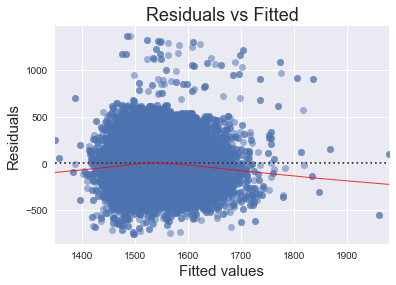

In [82]:
# model values
model_fitted_y = final.fittedvalues
# model residuals
model_residuals = final.resid
# normalized residuals
model_norm_residuals = final.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = final.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = final.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, dataframe.columns[-1], data=dataframe,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

/home/student.unimelb.edu.au/jmohammed/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


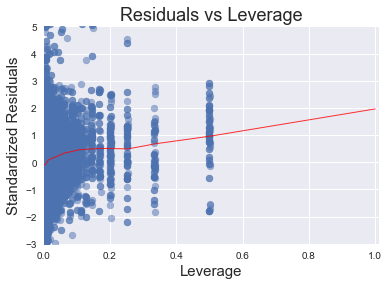

In [86]:
plot_lm_4 = plt.figure();
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
sns.regplot(model_leverage, model_norm_residuals,
          scatter=False,
          ci=False,
          lowess=True,
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals');

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
for i in leverage_top_3:
      plot_lm_4.axes[0].annotate(i,
                                 xy=(model_leverage[i],
                                     model_norm_residuals[i]));